In [7]:
import argparse
import logging
import os
import pprint
import threading
import time
import timeit
import traceback
import typing

os.environ["OMP_NUM_THREADS"] = "1"  # Necessary for multithreading.

import torch
from torch import multiprocessing as mp
from torch.multiprocessing import Process, Manager
from torch import nn
from torch.nn import functional as F

from torchbeast.core.environment import Environment, Vec_Environment
from torchbeast.atari_wrappers import SokobanWrapper
from torchbeast.base import BaseNet
from torchbeast.train import create_env

import gym
import gym_sokoban
import numpy as np
import math
import logging
from matplotlib import pyplot as plt
from collections import deque

logging.basicConfig(format='%(message)s', level=logging.DEBUG)
logging.getLogger('matplotlib.font_manager').disabled = True

torch.multiprocessing.set_sharing_strategy('file_system')

def get_param(net, name=None):
    keys = []
    for (k, v) in actor_wrapper.model.named_parameters(): 
        if name is None:
            print(k)
        else:
            if name == k: return v
        keys.append(k)
    return keys        

def n_step_greedy(env, net, n, temp=10.):    
    if isinstance(env, Vec_Environment):
        num_actions = env.gym_env.action_space[0].n
        bsz = len(env.gym_env.envs)
    else:
        num_actions = env.gym_env.action_space.n
        bsz = 1

    q_ret = torch.zeros(bsz, num_actions).to(device)      
    state = env.clone_state()

    for act in range(num_actions):
        obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
        obs = {k:v.to(device) for k, v in obs.items()}   
        
        if n > 1:
            action, prob, sub_q_ret = n_step_greedy(env, net, n-1)
            ret = obs['reward'] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] * (~obs['done']).float()
        else:
            ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()

        q_ret[:, act] = ret
        env.restore_state(state)
    
    prob = F.softmax(temp*q_ret, dim=1)
    action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret  


<font size="5">Testing planning algo. for perfect model with bootstrapped values</font>

In [14]:
# Synchronous version of testing 

def test_n_step(n, net, env, temp=10.):
    
    print("Testing %d step planning" % n)

    returns = []
    obs = env.initial()
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(device) for k, v in obs.items()}
        net_out, core_state = net(obs)            
        if n == 0:
            action = net_out["action"][0]
        else:
            action, _, _ = n_step_greedy(env, net, n, temp)
        obs = env.step(action)
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

bsz = 16    
eps_n = 500
device = torch.device("cuda")

# create environments

env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
num_actions = env.gym_env.action_space[0].n

# import the net

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   
flags.discounting = 0.97
temp = 5

net = BaseNet(observation_shape=(3,80,80), num_actions=num_actions, flags=flags)  
net = net.to(device)
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cuda")
#checkpoint = torch.load("/home/schk/RS/thinker/logs/base/torchbeast-20221105-033530/model.tar", map_location="cuda")
net.load_state_dict(checkpoint["model_state_dict"]) 

# initialize net

core_state = net.initial_state(batch_size=bsz)
core_state = tuple(v.to(device) for v in core_state)
net.train(False)

all_returns = {}
for n in range(2,3):
    t = time.process_time()
    all_returns[n] = test_n_step(n, net, env, temp)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

model size:  1095814
Testing 2 step planning
Finish 16 episode: avg. return: 0.36 (+-0.22) 
Finish 32 episode: avg. return: 0.46 (+-0.19) 
Finish 48 episode: avg. return: 0.59 (+-0.14) 
Finish 64 episode: avg. return: 0.61 (+-0.11) 


KeyboardInterrupt: 

In [15]:
# Asynchronous version of testing 

def act_m(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    returns: Manager().list,
    eps_n: int,
    n: int,
    temp: float,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        net_out, unused_state = net(env_output, agent_state)      
        while True:            
            if len(returns) >= eps_n: break
            with torch.no_grad():
                net_out, agent_state = net(env_output, agent_state)                            
            if n == 0:
                action = net_out["action"]
            else:
                action, _, _ = n_step_greedy(env, net, n, temp)            
            env_output = env.step(action)           
            if env_output['done']: returns.append(ret)
            ret = env_output['episode_return'].item()        
        #logging.info("Actor %i end", actor_index)
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e

def asy_test_n_step(n, net, flags, temp):
    
    print("Testing %d step planning" % n)

    mp.set_sharing_strategy('file_system')
    net.share_memory()
    ctx = mp.get_context()        
    returns = Manager().list()

    actor_processes = []
    for i in range(flags.num_actors):
        actor = ctx.Process(target=act_m, args=(flags, i, net, returns, eps_n, n, temp),)
        actor.start()
        actor_processes.append(actor)    

    for actor in actor_processes:
        actor.join()    

    print("Finish %d episode: avg. return: %.2f (+-%.2f)" % (len(returns),
                    np.average(returns), np.std(returns) / np.sqrt(len(returns)),))        
    return returns        
        
parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())   

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97     
flags.num_actors = 32
bsz = 1
eps_n = 500
temp = 5
device = torch.device("cpu")

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
net = net.to("cpu")
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"]) 

all_returns = {}
for n in range(4):
    t = time.time()
    all_returns[n] = asy_test_n_step(n, net, flags, temp)
    print("Time required for %d step planning: %f" %(n, time.time()-t))

model size:  1095814
Testing 0 step planning
Finish 500 episode: avg. return: 0.27 (+-0.04)
Time required for 0 step planning: 12.629324
Testing 1 step planning
Finish 502 episode: avg. return: 0.51 (+-0.04)
Time required for 1 step planning: 74.194364
Testing 2 step planning
Finish 500 episode: avg. return: 0.74 (+-0.04)
Time required for 2 step planning: 339.732901
Testing 3 step planning
Finish 500 episode: avg. return: 0.76 (+-0.04)
Time required for 3 step planning: 1695.472523


Results (base_1.tar):
    
Testing 0 step planning <br>
Finish 512 episode: avg. return: 0.12 (+-0.06) <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.61 (+-0.04) <br>
Testing 2 step planning <br>
Finish 501 episode: avg. return: 0.92 (+-0.04) <br>
Testing 3 step planning <br>
Finish 501 episode: avg. return: 1.01 (+-0.04) <br>

Results (base_2.tar):
Testing 0 step planning <br>
Finish 500 episode: avg. return: 0.27 (+-0.04) <br>
Time required for 0 step planning: 12.629324 <br>
Testing 1 step planning <br>
Finish 502 episode: avg. return: 0.51 (+-0.04) <br>
Time required for 1 step planning: 74.194364 <br>
Testing 2 step planning <br>
Finish 500 episode: avg. return: 0.74 (+-0.04) <br>
Time required for 2 step planning: 339.732901 <br>
Testing 3 step planning <br>
Finish 500 episode: avg. return: 0.76 (+-0.04) <br>
Time required for 3 step planning: 1695.472523 <br>

<font size="5">Model Training Phase</font>

In [34]:
# Generating data for learning model [RUN]

Buffers = typing.Dict[str, typing.List[torch.Tensor]]

def create_buffers_m(flags, obs_shape, num_actions) -> Buffers:
    
    seq_len = flags.seq_len
    seq_n = flags.seq_n
    specs = dict(
        frame=dict(size=(seq_len + 1, *obs_shape), dtype=torch.uint8),
        reward=dict(size=(seq_len + 1,), dtype=torch.float32),
        done=dict(size=(seq_len + 1,), dtype=torch.bool),
        truncated_done=dict(size=(seq_len + 1,), dtype=torch.bool),
        episode_return=dict(size=(seq_len + 1,), dtype=torch.float32),
        episode_step=dict(size=(seq_len + 1,), dtype=torch.int32),
        policy_logits=dict(size=(seq_len + 1, num_actions), dtype=torch.float32),
        baseline=dict(size=(seq_len + 1,), dtype=torch.float32),
        last_action=dict(size=(seq_len + 1,), dtype=torch.int64),
        action=dict(size=(seq_len + 1,), dtype=torch.int64),
        reg_loss=dict(size=(seq_len + 1,), dtype=torch.float32)
    )
    buffers: Buffers = {key: [] for key in specs}
    for _ in range(seq_n):
        for key in buffers:
            buffers[key].append(torch.empty(**specs[key]).share_memory_())
            
    return buffers

def gen_data(
    flags,
    actor_index: int,
    net: torch.nn.Module,
    buffers: Buffers,
    free_queue: mp.SimpleQueue,
):    
    try:    
        #logging.info("Actor %i started", actor_index)
        gym_env = create_env(flags)
        seed = actor_index ^ int.from_bytes(os.urandom(4), byteorder="little")
        gym_env.seed(seed)
        env = Environment(gym_env)
        env_output = env.initial()  
        agent_state = net.initial_state(batch_size=1)
        agent_output, unused_state = net(env_output, agent_state)     
        
        while True:
            index = free_queue.get()
            if index is None:
                break         

            # Write old rollout end.
            for key in env_output:
                buffers[key][index][0, ...] = env_output[key]
            for key in agent_output:
                buffers[key][index][0, ...] = agent_output[key]

            # Do new rollout.
            for t in range(flags.seq_len):
                with torch.no_grad():
                    agent_output, agent_state = net(env_output, agent_state)
                env_output = env.step(agent_output["action"])
                for key in env_output:
                    buffers[key][index][t + 1, ...] = env_output[key]
                for key in agent_output:
                    buffers[key][index][t + 1, ...] = agent_output[key]
                    
    except KeyboardInterrupt:
        pass  # Return silently.
    except Exception as e:
        logging.error("Exception in worker process %i", actor_index)
        traceback.print_exc()
        raise e
        

# Models

DOWNSCALE_C = 2

def conv3x3(in_planes: int, out_planes: int, stride: int = 1, groups: int = 1, dilation: int = 1) -> nn.Conv2d:
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=dilation,
        groups=groups, bias=False, dilation=dilation,)

def conv1x1(in_planes: int, out_planes: int, stride: int = 1) -> nn.Conv2d:
    """1x1 convolution"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False)

class ResBlock(nn.Module):
    expansion: int = 1

    def __init__(self, inplanes, outplanes=None):
        super().__init__()
        if outplanes is None: outplanes = inplanes 
        norm_layer = nn.BatchNorm2d
        self.conv1 = conv3x3(inplanes, inplanes)
        self.bn1 = norm_layer(inplanes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(inplanes, outplanes)
        self.bn2 = norm_layer(outplanes)
        self.skip_conv = (outplanes != inplanes)
        if outplanes != inplanes:
            self.conv3 = conv1x1(inplanes, outplanes)

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        if self.skip_conv:
            out += self.conv3(identity)
        else:
            out += identity
        out = self.relu(out)
        return out
    
class FrameEncoder(nn.Module):    
    def __init__(self, num_actions, frame_channels=3):
        self.num_actions = num_actions
        super(FrameEncoder, self).__init__() 
        self.conv1 = nn.Conv2d(in_channels=frame_channels+num_actions, out_channels=128//DOWNSCALE_C, kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=128//DOWNSCALE_C) for i in range(1)]) # Deep: 2 blocks here
        self.res1 = torch.nn.Sequential(*res)
        self.conv2 = nn.Conv2d(in_channels=128//DOWNSCALE_C, out_channels=256//DOWNSCALE_C, 
                               kernel_size=3, stride=2, padding=1) 
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(1)]) # Deep: 3 blocks here
        self.res2 = torch.nn.Sequential(*res)
        self.avg1 = nn.AvgPool2d(3, stride=2, padding=1)
        res = nn.ModuleList([ResBlock(inplanes=256//DOWNSCALE_C) for i in range(1)]) # Deep: 3 blocks here
        self.res3 = torch.nn.Sequential(*res)
        self.avg2 = nn.AvgPool2d(3, stride=2, padding=1)
    
    def forward(self, x, actions):        
        # input shape: B, C, H, W        
        # action shape: B 
        
        x = x.float() / 255.0    
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        x = F.relu(self.conv1(x))
        x = self.res1(x)
        x = F.relu(self.conv2(x))
        x = self.res2(x)
        x = self.avg1(x)
        x = self.res3(x)
        x = self.avg2(x)
        return x
    
class DynamicModel(nn.Module):
    def __init__(self, num_actions, inplanes=256):        
        super(DynamicModel, self).__init__()
        res = nn.ModuleList([ResBlock(inplanes=inplanes+num_actions, outplanes=inplanes)] + [
            ResBlock(inplanes=inplanes) for i in range(4)]) # Deep: 15 blocks here
        self.res = torch.nn.Sequential(*res)
        self.num_actions = num_actions
    
    def forward(self, x, actions):      
        actions = actions.unsqueeze(-1).unsqueeze(-1).tile([1, 1, x.shape[2], x.shape[3]])        
        x = torch.concat([x, actions], dim=1)
        return self.res(x)
    
class Output_rvpi(nn.Module):   
    def __init__(self, num_actions, input_shape):         
        super(Output_rvpi, self).__init__()        
        c, h, w = input_shape
        self.conv1 = nn.Conv2d(in_channels=c, out_channels=c//2, kernel_size=3, padding='same') 
        self.conv2 = nn.Conv2d(in_channels=c//2, out_channels=c//4, kernel_size=3, padding='same') 
        fc_in = h * w * (c // 4)
        self.fc_r = nn.Linear(fc_in, 1) 
        self.fc_v = nn.Linear(fc_in, 1) 
        self.fc_logits = nn.Linear(fc_in, num_actions)         
        
    def forward(self, x):    
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = torch.flatten(x, start_dim=1)
        r, v, logits = self.fc_r(x), self.fc_v(x), self.fc_logits(x)
        return r, v, logits

class Model(nn.Module):    
    def __init__(self, flags, obs_shape, num_actions):
        super(Model, self).__init__()      
        self.flags = flags
        self.obs_shape = obs_shape
        self.num_actions = num_actions          
        self.frameEncoder = FrameEncoder(num_actions=num_actions, frame_channels=obs_shape[0])
        self.dynamicModel = DynamicModel(num_actions=num_actions, inplanes=256//DOWNSCALE_C)
        self.output_rvpi = Output_rvpi(num_actions=num_actions, input_shape=(256//DOWNSCALE_C, 
                      obs_shape[1]//16, obs_shape[1]//16))
        
    def forward(self, x, actions, one_hot=False):
        # Input
        # x: frames with shape (B, C, H, W), in the form of s_t
        # actions: action (int64) with shape (k+1, B), in the form of a_{t-1}, a_{t}, a_{t+1}, .. a_{t+k-1}
        # Output
        # reward: predicted reward with shape (k, B), in the form of r_{t+1}, r_{t+2}, ..., r_{t+k}
        # value: predicted value with shape (k+1, B), in the form of v_{t}, v_{t+1}, v_{t+2}, ..., v_{t+k}
        # policy: predicted policy with shape (k+1, B), in the form of pi_{t}, pi_{t+1}, pi_{t+2}, ..., pi_{t+k}
        # encoded: encoded states with shape (k+1, B), in the form of z_t, z_{t+1}, z_{t+2}, ..., z_{t+k}
        # Recall the transition notation: s_t, a_t, r_{t+1}, s_{t+1}, ...
        
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        encoded = self.frameEncoder(x, actions[0])
        return self.forward_encoded(encoded, actions[1:], one_hot=True)
    
    def forward_encoded(self, encoded, actions, one_hot=False):
        if not one_hot:
            actions = F.one_hot(actions, self.num_actions)                
        
        r, v, logits = self.output_rvpi(encoded)
        r_list, v_list, logits_list = [], [v.squeeze(-1).unsqueeze(0)], [logits.unsqueeze(0)]
        encoded_list = [encoded.unsqueeze(0)]
        
        for k in range(actions.shape[0]):            
            encoded = self.dynamicModel(encoded, actions[k])
            r, v, logits = self.output_rvpi(encoded)
            r_list.append(r.squeeze(-1).unsqueeze(0))
            v_list.append(v.squeeze(-1).unsqueeze(0))
            logits_list.append(logits.unsqueeze(0))
            encoded_list.append(encoded.unsqueeze(0))        
        
        if len(r_list) > 0:
            rs = torch.concat(r_list, dim=0)
        else:
            rs = None
            
        vs = torch.concat(v_list, dim=0)
        logits = torch.concat(logits_list, dim=0)
        encodeds = torch.concat(encoded_list, dim=0)        
        
        return rs, vs, logits, encodeds

#model = Model(flags, (3, 80, 80), num_actions=5)
#rs, vs, logits = model(torch.rand(16, 3, 80, 80), torch.ones(8, 16).long())

# functions for training models

def get_batch_m(flags, buffers: Buffers):
    batch_indices = np.random.randint(flags.seq_n, size=flags.bsz)
    time_indices = np.random.randint(flags.seq_len - flags.unroll_len, size=flags.bsz)
    batch = {key: torch.stack([buffers[key][m][time_indices[n]:time_indices[n]+flags.unroll_len+1] 
                          for n, m in enumerate(batch_indices)], dim=1) for key in buffers}
    batch = {k: t.to(device=flags.device, non_blocking=True) for k, t in batch.items()}
    return batch

def compute_cross_entropy_loss(logits, target_logits, mask):
    target_policy = F.softmax(target_logits, dim=-1)
    log_policy = F.log_softmax(logits, dim=-1)
    return -torch.sum(target_policy * log_policy * (~mask).float().unsqueeze(-1))

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_rewards = batch['reward'][1:]
    target_logits = batch['policy_logits'][1:]

    target_vs = []
    target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float())# +
                           #vs[t-1] * (batch['truncated_done'][t]).float())
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)

    # if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
    # rs is stored in the form of r_{t+1}, ..., r_{t+k}
    # vs is stored in the form of v_{t}, ..., v_{t+k-1}
    # logits is stored in the form of a{t}, ..., a_{t+k-1}

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
    for t in range(vs.shape[0]):
        done = torch.logical_or(done, batch['done'][t])
        done_masks.append(done.unsqueeze(0))

    done_masks = torch.concat(done_masks[:-1], dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()) * (~done_masks).float())
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()) * (~done_masks).float())
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), done_masks)
    
    return rs_loss, vs_loss, logits_loss

# n_step_greedy for testing

def n_step_greedy_model(state, action, model, n, encoded=None, temp=20.): 
    
    # Either input state, action (S_t, A_{t-1}) or the encoded Z_t
    # state / encoded in the shape of (B, C, H, W)
    # action in the shape of (B)    
    with torch.no_grad():    
      bsz = state.shape[0] if encoded is None else encoded.shape[0]
      device = state.device if encoded is None else encoded.device
      num_actions = model.num_actions    

      q_ret = torch.zeros(bsz, num_actions).to(device)        

      for act in range(num_actions):        
          new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
          if encoded is None:            
              old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
              rs, vs, logits, encodeds = model(state, old_new_actions)
          else:
              rs, vs, logits, encodeds = model.forward_encoded(encoded, new_action.unsqueeze(0))

          if n > 1:
              action, prob, sub_q_ret = n_step_greedy_model(state=None, action=None, 
                         model=model, n=n-1, encoded=encodeds[1])
              ret = rs[0] + flags.discounting * torch.max(sub_q_ret, dim=1)[0] 
          else:
              ret = rs[0] + flags.discounting * vs[1]
          q_ret[:, act] = ret

      prob = F.softmax(temp*q_ret, dim=1)
      action = torch.multinomial(prob, num_samples=1)[:, 0]
    
    return action, prob, q_ret        
   
#n_step_greedy_model(batch['frame'][0], batch['action'][0], model, 4)  

def test_n_step_model(n, model, flags, eps_n=100, temp=20.):    
    
    print("Testing %d step planning" % n) 
    
    bsz = 100
    env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
    env = Vec_Environment(env, bsz)
    num_actions = env.gym_env.action_space[0].n
    
    model.train(False)
    returns = []
    
    obs = env.initial()
    action = torch.zeros(bsz).long().to(flags.device)
    eps_n_cur = 5

    while(len(returns) <= eps_n):
        cur_returns = obs['episode_return']    
        obs = {k:v.to(flags.device) for k, v in obs.items()}
        new_action, _, _ = n_step_greedy_model(obs['frame'][0], action, model, n, None, temp)        
        obs = env.step(new_action)
        action = new_action
        if torch.any(obs['done']):
            returns.extend(cur_returns[obs['done']].numpy())
        if eps_n_cur <= len(returns) and len(returns) > 0: 
            eps_n_cur = len(returns) + 10
            #print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            #    np.average(returns), np.std(returns) / np.sqrt(len(returns))))
            
    returns = returns[:eps_n]
    print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
                np.average(returns), np.std(returns) / np.sqrt(len(returns))))
    return returns

In [35]:
# Start training models

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())       

flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.bsz = 32
flags.unroll_len = 3
flags.num_actors = 32
flags.seq_n = 1000
flags.seq_len = 200
flags.learning_rate = 0.0002
flags.loop_batch_n = 3
flags.discounting = 0.97
flags.tot_epoch = 10000
flags.device = torch.device("cuda")

# Create buffer for actors to write

mp.set_sharing_strategy('file_system')
ctx = mp.get_context()        

env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n
buffers = create_buffers_m(flags, obs_shape, num_actions)
print("Buffer created successfully.")

# Initialize the model and optimizer

env = create_env(flags)
model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
optimizer = torch.optim.Adam(model.parameters(), lr=flags.learning_rate)

print("model size: ", sum(p.numel() for p in model.parameters()))
for k, v in model.named_parameters(): print(k, v.numel())    
    
tot_step = int(flags.loop_batch_n * flags.seq_n * flags.seq_len / flags.bsz / flags.unroll_len) 

Buffer created successfully.
model size:  2352882
frameEncoder.conv1.weight 4608
frameEncoder.conv1.bias 64
frameEncoder.res1.0.conv1.weight 36864
frameEncoder.res1.0.bn1.weight 64
frameEncoder.res1.0.bn1.bias 64
frameEncoder.res1.0.conv2.weight 36864
frameEncoder.res1.0.bn2.weight 64
frameEncoder.res1.0.bn2.bias 64
frameEncoder.conv2.weight 73728
frameEncoder.conv2.bias 128
frameEncoder.res2.0.conv1.weight 147456
frameEncoder.res2.0.bn1.weight 128
frameEncoder.res2.0.bn1.bias 128
frameEncoder.res2.0.conv2.weight 147456
frameEncoder.res2.0.bn2.weight 128
frameEncoder.res2.0.bn2.bias 128
frameEncoder.res3.0.conv1.weight 147456
frameEncoder.res3.0.bn1.weight 128
frameEncoder.res3.0.bn1.bias 128
frameEncoder.res3.0.conv2.weight 147456
frameEncoder.res3.0.bn2.weight 128
frameEncoder.res3.0.bn2.bias 128
dynamicModel.res.0.conv1.weight 159201
dynamicModel.res.0.bn1.weight 133
dynamicModel.res.0.bn1.bias 133
dynamicModel.res.0.conv2.weight 153216
dynamicModel.res.0.bn2.weight 128
dynamicModel

In [19]:
temp = 5.

# Load the preset policy

net = BaseNet(observation_shape=(3,80,80), num_actions=5, flags=flags)  
checkpoint = torch.load("/home/schk/RS/thinker/models/base_2.tar", map_location="cpu")
net.load_state_dict(checkpoint["model_state_dict"])   
net.train(False)
net.share_memory()

# Get the actors to write on the buffer

actor_processes = []
free_queue = mp.SimpleQueue()
loss_stats = [deque(maxlen=400) for _ in range(4)]

net.train(False)
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

# Start training loop    

model.train(True)
for epoch in range(flags.tot_epoch):    
    print("Batch [%d] starts" % epoch)
    while(not free_queue.empty()): time.sleep(1)
    for step in range(tot_step):
        if step == 0: 
            test_n_step_model(1, model, flags, eps_n=100, temp=temp)
            model.train(True)
        
        batch = get_batch_m(flags, buffers)
        rs_loss, vs_loss, logits_loss = compute_loss_m(model, batch)
        tot_loss = rs_loss + vs_loss + 0.05 * logits_loss
        for n, l in enumerate([tot_loss, rs_loss, vs_loss, logits_loss]):
            loss_stats[n].append(l.item())
        
        if step % 100 == 0:
            print("[%d:%d] F: %d \t tot_loss %f rs_loss %f vs_loss %f logits_loss %f" % ((
                epoch, step, (step + epoch * tot_step) * flags.bsz * flags.unroll_len,) +
                tuple(np.average(l) for l in loss_stats)))
        optimizer.zero_grad()
        tot_loss.backward()
        optimizer.step()    
    for m in range(flags.seq_n): free_queue.put(m)
        
for _ in range(flags.num_actors): free_queue.put(None)        
for actor in actor_processes: actor.join(timeout=1)        

model size:  1095814
Batch [0] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.85 (+-0.06) 
[0:0] F: 0 	 tot_loss 31.412720 rs_loss 12.127158 vs_loss 11.798643 logits_loss 149.738403
[0:100] F: 9600 	 tot_loss 10.489563 rs_loss 1.093408 vs_loss 1.963170 logits_loss 148.659694
[0:200] F: 19200 	 tot_loss 10.237407 rs_loss 1.001062 vs_loss 1.835907 logits_loss 148.008782
[0:300] F: 28800 	 tot_loss 10.119629 rs_loss 0.958913 vs_loss 1.761552 logits_loss 147.983300
[0:400] F: 38400 	 tot_loss 10.025569 rs_loss 0.916511 vs_loss 1.713362 logits_loss 147.913907
[0:500] F: 48000 	 tot_loss 9.768834 rs_loss 0.831759 vs_loss 1.553641 logits_loss 147.668655
[0:600] F: 57600 	 tot_loss 9.554952 rs_loss 0.757879 vs_loss 1.417541 logits_loss 147.590648
[0:700] F: 67200 	 tot_loss 9.429279 rs_loss 0.721470 vs_loss 1.341246 logits_loss 147.331269
[0:800] F: 76800 	 tot_loss 9.247243 rs_loss 0.663996 vs_loss 1.232054 logits_loss 147.023865
[0:900] F: 86400 	 tot_loss 9.276123 rs_los

[1:2100] F: 801600 	 tot_loss 8.496630 rs_loss 0.617685 vs_loss 1.296238 logits_loss 131.654140
[1:2200] F: 811200 	 tot_loss 8.499312 rs_loss 0.620892 vs_loss 1.302410 logits_loss 131.520200
[1:2300] F: 820800 	 tot_loss 8.453572 rs_loss 0.618202 vs_loss 1.270241 logits_loss 131.302579
[1:2400] F: 830400 	 tot_loss 8.334602 rs_loss 0.577469 vs_loss 1.190457 logits_loss 131.333533
[1:2500] F: 840000 	 tot_loss 8.206642 rs_loss 0.546674 vs_loss 1.090678 logits_loss 131.385819
[1:2600] F: 849600 	 tot_loss 8.182158 rs_loss 0.523237 vs_loss 1.094809 logits_loss 131.282252
[1:2700] F: 859200 	 tot_loss 8.173522 rs_loss 0.510099 vs_loss 1.087494 logits_loss 131.518565
[1:2800] F: 868800 	 tot_loss 8.335642 rs_loss 0.566286 vs_loss 1.206568 logits_loss 131.255739
[1:2900] F: 878400 	 tot_loss 8.625595 rs_loss 0.665342 vs_loss 1.403503 logits_loss 131.134995
[1:3000] F: 888000 	 tot_loss 8.768502 rs_loss 0.736567 vs_loss 1.482653 logits_loss 130.985628
[1:3100] F: 897600 	 tot_loss 8.966936 r

[2:4200] F: 1603200 	 tot_loss 7.860138 rs_loss 0.365131 vs_loss 1.090903 logits_loss 128.082064
[2:4300] F: 1612800 	 tot_loss 7.711450 rs_loss 0.315041 vs_loss 0.989141 logits_loss 128.145339
[2:4400] F: 1622400 	 tot_loss 7.787088 rs_loss 0.335345 vs_loss 1.036070 logits_loss 128.313465
[2:4500] F: 1632000 	 tot_loss 7.764541 rs_loss 0.330410 vs_loss 1.017992 logits_loss 128.322770
[2:4600] F: 1641600 	 tot_loss 7.802283 rs_loss 0.330317 vs_loss 1.064813 logits_loss 128.143051
[2:4700] F: 1651200 	 tot_loss 8.006921 rs_loss 0.414604 vs_loss 1.196729 logits_loss 127.911762
[2:4800] F: 1660800 	 tot_loss 7.997725 rs_loss 0.420250 vs_loss 1.190842 logits_loss 127.732654
[2:4900] F: 1670400 	 tot_loss 8.133379 rs_loss 0.464213 vs_loss 1.276212 logits_loss 127.859061
[2:5000] F: 1680000 	 tot_loss 8.004659 rs_loss 0.431745 vs_loss 1.184935 logits_loss 127.759580
[2:5100] F: 1689600 	 tot_loss 7.968961 rs_loss 0.402816 vs_loss 1.177624 logits_loss 127.770404
[2:5200] F: 1699200 	 tot_loss

Batch [4] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.36 (+-0.08) 
[4:0] F: 2400000 	 tot_loss 7.640826 rs_loss 0.305346 vs_loss 1.049919 logits_loss 125.711223
[4:100] F: 2409600 	 tot_loss 7.670875 rs_loss 0.308049 vs_loss 1.067206 logits_loss 125.912408
[4:200] F: 2419200 	 tot_loss 7.602986 rs_loss 0.266957 vs_loss 1.029124 logits_loss 126.138119
[4:300] F: 2428800 	 tot_loss 7.522819 rs_loss 0.236336 vs_loss 0.981851 logits_loss 126.092653
[4:400] F: 2438400 	 tot_loss 7.438647 rs_loss 0.234159 vs_loss 0.897039 logits_loss 126.148985
[4:500] F: 2448000 	 tot_loss 7.276044 rs_loss 0.188018 vs_loss 0.785447 logits_loss 126.051584
[4:600] F: 2457600 	 tot_loss 7.281548 rs_loss 0.188191 vs_loss 0.791988 logits_loss 126.027388
[4:700] F: 2467200 	 tot_loss 7.415973 rs_loss 0.255639 vs_loss 0.855477 logits_loss 126.097141
[4:800] F: 2476800 	 tot_loss 7.370998 rs_loss 0.235366 vs_loss 0.830191 logits_loss 126.108801
[4:900] F: 2486400 	 tot_loss 7.380445 rs_loss 0

[5:2000] F: 3192000 	 tot_loss 7.169198 rs_loss 0.149763 vs_loss 0.758761 logits_loss 125.213470
[5:2100] F: 3201600 	 tot_loss 7.174175 rs_loss 0.156444 vs_loss 0.755232 logits_loss 125.249986
[5:2200] F: 3211200 	 tot_loss 7.239128 rs_loss 0.186655 vs_loss 0.800325 logits_loss 125.042963
[5:2300] F: 3220800 	 tot_loss 7.236779 rs_loss 0.181366 vs_loss 0.802262 logits_loss 125.063013
[5:2400] F: 3230400 	 tot_loss 7.333910 rs_loss 0.198863 vs_loss 0.886926 logits_loss 124.962425
[5:2500] F: 3240000 	 tot_loss 7.325291 rs_loss 0.190798 vs_loss 0.889218 logits_loss 124.905507
[5:2600] F: 3249600 	 tot_loss 7.237264 rs_loss 0.159542 vs_loss 0.842983 logits_loss 124.694789
[5:2700] F: 3259200 	 tot_loss 7.206619 rs_loss 0.164486 vs_loss 0.813441 logits_loss 124.573835
[5:2800] F: 3268800 	 tot_loss 7.132605 rs_loss 0.146322 vs_loss 0.747578 logits_loss 124.774078
[5:2900] F: 3278400 	 tot_loss 7.142328 rs_loss 0.150585 vs_loss 0.751718 logits_loss 124.800497
[5:3000] F: 3288000 	 tot_loss

[6:4100] F: 3993600 	 tot_loss 7.198776 rs_loss 0.195494 vs_loss 0.840142 logits_loss 123.262803
[6:4200] F: 4003200 	 tot_loss 7.378460 rs_loss 0.243231 vs_loss 0.964504 logits_loss 123.414518
[6:4300] F: 4012800 	 tot_loss 7.287929 rs_loss 0.216203 vs_loss 0.908336 logits_loss 123.267797
[6:4400] F: 4022400 	 tot_loss 7.189839 rs_loss 0.185614 vs_loss 0.831593 logits_loss 123.452624
[6:4500] F: 4032000 	 tot_loss 7.068335 rs_loss 0.128475 vs_loss 0.753923 logits_loss 123.718745
[6:4600] F: 4041600 	 tot_loss 6.914824 rs_loss 0.084850 vs_loss 0.647475 logits_loss 123.649967
[6:4700] F: 4051200 	 tot_loss 6.984845 rs_loss 0.121739 vs_loss 0.672938 logits_loss 123.803369
[6:4800] F: 4060800 	 tot_loss 7.016823 rs_loss 0.130798 vs_loss 0.690339 logits_loss 123.913723
[6:4900] F: 4070400 	 tot_loss 7.223955 rs_loss 0.205894 vs_loss 0.831984 logits_loss 123.721539
[6:5000] F: 4080000 	 tot_loss 7.292978 rs_loss 0.227489 vs_loss 0.879399 logits_loss 123.721812
[6:5100] F: 4089600 	 tot_loss

[7:6200] F: 4795200 	 tot_loss 7.070941 rs_loss 0.158685 vs_loss 0.806590 logits_loss 122.113327
Batch [8] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.12 (+-0.09) 
[8:0] F: 4800000 	 tot_loss 7.161080 rs_loss 0.181902 vs_loss 0.871898 logits_loss 122.145608
[8:100] F: 4809600 	 tot_loss 7.092304 rs_loss 0.164018 vs_loss 0.811476 logits_loss 122.336191
[8:200] F: 4819200 	 tot_loss 7.186691 rs_loss 0.191345 vs_loss 0.869865 logits_loss 122.509607
[8:300] F: 4828800 	 tot_loss 7.330579 rs_loss 0.241249 vs_loss 0.945317 logits_loss 122.880259
[8:400] F: 4838400 	 tot_loss 7.333165 rs_loss 0.239998 vs_loss 0.928985 logits_loss 123.283633
[8:500] F: 4848000 	 tot_loss 7.325083 rs_loss 0.239113 vs_loss 0.930305 logits_loss 123.113310
[8:600] F: 4857600 	 tot_loss 7.283378 rs_loss 0.212837 vs_loss 0.901006 logits_loss 123.390698
[8:700] F: 4867200 	 tot_loss 7.255071 rs_loss 0.176699 vs_loss 0.908876 logits_loss 123.389938
[8:800] F: 4876800 	 tot_loss 7.381644 rs_loss 

[9:1900] F: 5582400 	 tot_loss 7.175905 rs_loss 0.202118 vs_loss 0.811403 logits_loss 123.247679
[9:2000] F: 5592000 	 tot_loss 7.401554 rs_loss 0.269498 vs_loss 0.970911 logits_loss 123.222901
[9:2100] F: 5601600 	 tot_loss 7.373969 rs_loss 0.248766 vs_loss 0.974654 logits_loss 123.010986
[9:2200] F: 5611200 	 tot_loss 7.366872 rs_loss 0.225682 vs_loss 0.993682 logits_loss 122.950174
[9:2300] F: 5620800 	 tot_loss 7.368877 rs_loss 0.229395 vs_loss 0.987393 logits_loss 123.041778
[9:2400] F: 5630400 	 tot_loss 7.172896 rs_loss 0.167212 vs_loss 0.843049 logits_loss 123.252700
[9:2500] F: 5640000 	 tot_loss 7.153120 rs_loss 0.161567 vs_loss 0.829832 logits_loss 123.234410
[9:2600] F: 5649600 	 tot_loss 7.309112 rs_loss 0.210961 vs_loss 0.938368 logits_loss 123.195667
[9:2700] F: 5659200 	 tot_loss 7.312305 rs_loss 0.216097 vs_loss 0.943264 logits_loss 123.058882
[9:2800] F: 5668800 	 tot_loss 7.299077 rs_loss 0.218778 vs_loss 0.944237 logits_loss 122.721248
[9:2900] F: 5678400 	 tot_loss

[10:4000] F: 6384000 	 tot_loss 7.059137 rs_loss 0.162546 vs_loss 0.805284 logits_loss 121.826153
[10:4100] F: 6393600 	 tot_loss 7.115749 rs_loss 0.184430 vs_loss 0.837044 logits_loss 121.885504
[10:4200] F: 6403200 	 tot_loss 7.438186 rs_loss 0.276719 vs_loss 1.055649 logits_loss 122.116351
[10:4300] F: 6412800 	 tot_loss 7.366944 rs_loss 0.254203 vs_loss 1.013955 logits_loss 121.975707
[10:4400] F: 6422400 	 tot_loss 7.229116 rs_loss 0.212907 vs_loss 0.922303 logits_loss 121.878119
[10:4500] F: 6432000 	 tot_loss 7.268736 rs_loss 0.209089 vs_loss 0.952836 logits_loss 122.136235
[10:4600] F: 6441600 	 tot_loss 7.006340 rs_loss 0.134057 vs_loss 0.766162 logits_loss 122.122420
[10:4700] F: 6451200 	 tot_loss 7.016163 rs_loss 0.130069 vs_loss 0.779638 logits_loss 122.129124
[10:4800] F: 6460800 	 tot_loss 7.139304 rs_loss 0.171816 vs_loss 0.856307 logits_loss 122.223618
[10:4900] F: 6470400 	 tot_loss 7.133431 rs_loss 0.180736 vs_loss 0.856840 logits_loss 121.917112
[10:5000] F: 6480000

[11:6000] F: 7176000 	 tot_loss 6.992450 rs_loss 0.180848 vs_loss 0.801298 logits_loss 120.206086
[11:6100] F: 7185600 	 tot_loss 7.023801 rs_loss 0.184646 vs_loss 0.834697 logits_loss 120.089159
[11:6200] F: 7195200 	 tot_loss 6.931111 rs_loss 0.157828 vs_loss 0.773013 logits_loss 120.005392
Batch [12] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.05 (+-0.08) 
[12:0] F: 7200000 	 tot_loss 6.904033 rs_loss 0.158284 vs_loss 0.749492 logits_loss 119.925121
[12:100] F: 7209600 	 tot_loss 7.149747 rs_loss 0.210022 vs_loss 0.908172 logits_loss 120.631054
[12:200] F: 7219200 	 tot_loss 7.013691 rs_loss 0.168456 vs_loss 0.774054 logits_loss 121.423635
[12:300] F: 7228800 	 tot_loss 7.141307 rs_loss 0.194706 vs_loss 0.847630 logits_loss 121.979413
[12:400] F: 7238400 	 tot_loss 7.260878 rs_loss 0.199575 vs_loss 0.942479 logits_loss 122.376476
[12:500] F: 7248000 	 tot_loss 7.084602 rs_loss 0.149018 vs_loss 0.816040 logits_loss 122.390891
[12:600] F: 7257600 	 tot_loss 6.97

[13:1600] F: 7953600 	 tot_loss 7.211788 rs_loss 0.174825 vs_loss 0.932021 logits_loss 122.098834
[13:1700] F: 7963200 	 tot_loss 7.249443 rs_loss 0.178482 vs_loss 0.958294 logits_loss 122.253344
[13:1800] F: 7972800 	 tot_loss 7.232434 rs_loss 0.180629 vs_loss 0.960758 logits_loss 121.820931
[13:1900] F: 7982400 	 tot_loss 7.234903 rs_loss 0.206382 vs_loss 0.940815 logits_loss 121.754116
[13:2000] F: 7992000 	 tot_loss 7.226429 rs_loss 0.217009 vs_loss 0.924921 logits_loss 121.689976
[13:2100] F: 8001600 	 tot_loss 7.392270 rs_loss 0.259883 vs_loss 1.055879 logits_loss 121.530152
[13:2200] F: 8011200 	 tot_loss 7.309073 rs_loss 0.239590 vs_loss 0.983901 logits_loss 121.711630
[13:2300] F: 8020800 	 tot_loss 7.111607 rs_loss 0.164319 vs_loss 0.860622 logits_loss 121.733314
[13:2400] F: 8030400 	 tot_loss 7.091045 rs_loss 0.154780 vs_loss 0.844186 logits_loss 121.841585
[13:2500] F: 8040000 	 tot_loss 7.006890 rs_loss 0.155515 vs_loss 0.753700 logits_loss 121.953505
[13:2600] F: 8049600

[14:3600] F: 8745600 	 tot_loss 6.865317 rs_loss 0.103079 vs_loss 0.707172 logits_loss 121.101316
[14:3700] F: 8755200 	 tot_loss 6.964078 rs_loss 0.129054 vs_loss 0.787604 logits_loss 120.948394
[14:3800] F: 8764800 	 tot_loss 6.917771 rs_loss 0.107016 vs_loss 0.752532 logits_loss 121.164445
[14:3900] F: 8774400 	 tot_loss 7.161548 rs_loss 0.184911 vs_loss 0.910046 logits_loss 121.331795
[14:4000] F: 8784000 	 tot_loss 7.234307 rs_loss 0.208254 vs_loss 0.954507 logits_loss 121.430914
[14:4100] F: 8793600 	 tot_loss 7.200720 rs_loss 0.212740 vs_loss 0.909315 logits_loss 121.573294
[14:4200] F: 8803200 	 tot_loss 7.306668 rs_loss 0.240278 vs_loss 0.988958 logits_loss 121.548638
[14:4300] F: 8812800 	 tot_loss 7.222762 rs_loss 0.215805 vs_loss 0.947382 logits_loss 121.191487
[14:4400] F: 8822400 	 tot_loss 7.164262 rs_loss 0.193003 vs_loss 0.907459 logits_loss 121.276011
[14:4500] F: 8832000 	 tot_loss 7.107821 rs_loss 0.162956 vs_loss 0.889895 logits_loss 121.099401
[14:4600] F: 8841600

[15:5600] F: 9537600 	 tot_loss 7.028932 rs_loss 0.174008 vs_loss 0.827109 logits_loss 120.556304
[15:5700] F: 9547200 	 tot_loss 7.061898 rs_loss 0.180494 vs_loss 0.851094 logits_loss 120.606203
[15:5800] F: 9556800 	 tot_loss 6.942697 rs_loss 0.161803 vs_loss 0.766547 logits_loss 120.286952
[15:5900] F: 9566400 	 tot_loss 6.840465 rs_loss 0.130172 vs_loss 0.695334 logits_loss 120.299194
[15:6000] F: 9576000 	 tot_loss 7.010235 rs_loss 0.170231 vs_loss 0.815356 logits_loss 120.492945
[15:6100] F: 9585600 	 tot_loss 7.073951 rs_loss 0.192858 vs_loss 0.846124 logits_loss 120.699371
[15:6200] F: 9595200 	 tot_loss 7.018986 rs_loss 0.164674 vs_loss 0.808806 logits_loss 120.910118
Batch [16] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.11 (+-0.08) 
[16:0] F: 9600000 	 tot_loss 7.023078 rs_loss 0.175074 vs_loss 0.810924 logits_loss 120.741586
[16:100] F: 9609600 	 tot_loss 7.112967 rs_loss 0.185513 vs_loss 0.856273 logits_loss 121.423624
[16:200] F: 9619200 	 tot_loss 

[17:1200] F: 10315200 	 tot_loss 7.117506 rs_loss 0.173409 vs_loss 0.852164 logits_loss 121.838676
[17:1300] F: 10324800 	 tot_loss 7.162788 rs_loss 0.199441 vs_loss 0.894110 logits_loss 121.384737
[17:1400] F: 10334400 	 tot_loss 7.173962 rs_loss 0.191615 vs_loss 0.899994 logits_loss 121.647041
[17:1500] F: 10344000 	 tot_loss 6.982782 rs_loss 0.143684 vs_loss 0.766842 logits_loss 121.445121
[17:1600] F: 10353600 	 tot_loss 7.078238 rs_loss 0.190111 vs_loss 0.820511 logits_loss 121.352314
[17:1700] F: 10363200 	 tot_loss 6.920092 rs_loss 0.147108 vs_loss 0.709036 logits_loss 121.278952
[17:1800] F: 10372800 	 tot_loss 6.996035 rs_loss 0.175221 vs_loss 0.762101 logits_loss 121.174257
[17:1900] F: 10382400 	 tot_loss 6.974618 rs_loss 0.163028 vs_loss 0.745522 logits_loss 121.321365
[17:2000] F: 10392000 	 tot_loss 7.028410 rs_loss 0.171389 vs_loss 0.784313 logits_loss 121.454171
[17:2100] F: 10401600 	 tot_loss 7.111845 rs_loss 0.189171 vs_loss 0.832573 logits_loss 121.802006
[17:2200] 

[18:3100] F: 11097600 	 tot_loss 7.070258 rs_loss 0.170005 vs_loss 0.843880 logits_loss 121.127459
[18:3200] F: 11107200 	 tot_loss 7.142027 rs_loss 0.193071 vs_loss 0.900087 logits_loss 120.977376
[18:3300] F: 11116800 	 tot_loss 6.941890 rs_loss 0.147750 vs_loss 0.748893 logits_loss 120.904936
[18:3400] F: 11126400 	 tot_loss 6.880039 rs_loss 0.126002 vs_loss 0.705013 logits_loss 120.980482
[18:3500] F: 11136000 	 tot_loss 6.882462 rs_loss 0.149976 vs_loss 0.689691 logits_loss 120.855895
[18:3600] F: 11145600 	 tot_loss 6.975235 rs_loss 0.185038 vs_loss 0.752870 logits_loss 120.746538
[18:3700] F: 11155200 	 tot_loss 6.973628 rs_loss 0.188324 vs_loss 0.751220 logits_loss 120.681659
[18:3800] F: 11164800 	 tot_loss 7.048508 rs_loss 0.207583 vs_loss 0.802954 logits_loss 120.759403
[18:3900] F: 11174400 	 tot_loss 7.029390 rs_loss 0.174811 vs_loss 0.815506 logits_loss 120.781441
[18:4000] F: 11184000 	 tot_loss 6.875466 rs_loss 0.113678 vs_loss 0.710766 logits_loss 121.020445
[18:4100] 

[19:5000] F: 11880000 	 tot_loss 7.132267 rs_loss 0.187609 vs_loss 0.895913 logits_loss 120.974905
[19:5100] F: 11889600 	 tot_loss 7.071883 rs_loss 0.167348 vs_loss 0.860019 logits_loss 120.890300
[19:5200] F: 11899200 	 tot_loss 6.943163 rs_loss 0.115940 vs_loss 0.780008 logits_loss 120.944306
[19:5300] F: 11908800 	 tot_loss 6.834004 rs_loss 0.087039 vs_loss 0.692697 logits_loss 121.085348
[19:5400] F: 11918400 	 tot_loss 6.731850 rs_loss 0.070480 vs_loss 0.615729 logits_loss 120.912832
[19:5500] F: 11928000 	 tot_loss 6.762130 rs_loss 0.088421 vs_loss 0.634369 logits_loss 120.786798
[19:5600] F: 11937600 	 tot_loss 6.752680 rs_loss 0.088889 vs_loss 0.632218 logits_loss 120.631448
[19:5700] F: 11947200 	 tot_loss 6.643270 rs_loss 0.069743 vs_loss 0.558217 logits_loss 120.306189
[19:5800] F: 11956800 	 tot_loss 6.629026 rs_loss 0.063420 vs_loss 0.544403 logits_loss 120.424049
[19:5900] F: 11966400 	 tot_loss 6.593845 rs_loss 0.063251 vs_loss 0.502792 logits_loss 120.556053
[19:6000] 

[21:600] F: 12657600 	 tot_loss 6.985091 rs_loss 0.174295 vs_loss 0.774792 logits_loss 120.720077
[21:700] F: 12667200 	 tot_loss 7.054930 rs_loss 0.204720 vs_loss 0.822708 logits_loss 120.550048
[21:800] F: 12676800 	 tot_loss 6.966763 rs_loss 0.164299 vs_loss 0.773181 logits_loss 120.585668
[21:900] F: 12686400 	 tot_loss 6.831087 rs_loss 0.117138 vs_loss 0.676802 logits_loss 120.742936
[21:1000] F: 12696000 	 tot_loss 6.894420 rs_loss 0.146625 vs_loss 0.716526 logits_loss 120.625382
[21:1100] F: 12705600 	 tot_loss 6.805073 rs_loss 0.116167 vs_loss 0.674206 logits_loss 120.293999
[21:1200] F: 12715200 	 tot_loss 6.878306 rs_loss 0.129413 vs_loss 0.729334 logits_loss 120.391186
[21:1300] F: 12724800 	 tot_loss 6.895354 rs_loss 0.152229 vs_loss 0.730531 logits_loss 120.251875
[21:1400] F: 12734400 	 tot_loss 6.844446 rs_loss 0.129001 vs_loss 0.703859 logits_loss 120.231723
[21:1500] F: 12744000 	 tot_loss 6.926592 rs_loss 0.151061 vs_loss 0.749860 logits_loss 120.513412
[21:1600] F: 1

[22:2600] F: 13449600 	 tot_loss 6.690941 rs_loss 0.096615 vs_loss 0.576680 logits_loss 120.352931
[22:2700] F: 13459200 	 tot_loss 6.900821 rs_loss 0.164098 vs_loss 0.709878 logits_loss 120.536882
[22:2800] F: 13468800 	 tot_loss 6.964291 rs_loss 0.167952 vs_loss 0.776025 logits_loss 120.406270
[22:2900] F: 13478400 	 tot_loss 7.056652 rs_loss 0.194242 vs_loss 0.834954 logits_loss 120.549101
[22:3000] F: 13488000 	 tot_loss 7.045446 rs_loss 0.189227 vs_loss 0.838295 logits_loss 120.358476
[22:3100] F: 13497600 	 tot_loss 6.774065 rs_loss 0.099250 vs_loss 0.665080 logits_loss 120.194712
[22:3200] F: 13507200 	 tot_loss 6.740965 rs_loss 0.094680 vs_loss 0.623516 logits_loss 120.455362
[22:3300] F: 13516800 	 tot_loss 6.666972 rs_loss 0.070665 vs_loss 0.570696 logits_loss 120.512233
[22:3400] F: 13526400 	 tot_loss 6.788754 rs_loss 0.113961 vs_loss 0.646315 logits_loss 120.569559
[22:3500] F: 13536000 	 tot_loss 6.789531 rs_loss 0.107761 vs_loss 0.657432 logits_loss 120.486772
[22:3600] 

[23:4500] F: 14232000 	 tot_loss 6.877145 rs_loss 0.143903 vs_loss 0.722044 logits_loss 120.223959
[23:4600] F: 14241600 	 tot_loss 6.931762 rs_loss 0.141216 vs_loss 0.783228 logits_loss 120.146367
[23:4700] F: 14251200 	 tot_loss 6.962382 rs_loss 0.168377 vs_loss 0.789362 logits_loss 120.092854
[23:4800] F: 14260800 	 tot_loss 6.977921 rs_loss 0.174894 vs_loss 0.788874 logits_loss 120.283052
[23:4900] F: 14270400 	 tot_loss 6.805198 rs_loss 0.135587 vs_loss 0.645259 logits_loss 120.487032
[23:5000] F: 14280000 	 tot_loss 6.705251 rs_loss 0.115640 vs_loss 0.558407 logits_loss 120.624074
[23:5100] F: 14289600 	 tot_loss 6.694809 rs_loss 0.095522 vs_loss 0.560122 logits_loss 120.783313
[23:5200] F: 14299200 	 tot_loss 6.617577 rs_loss 0.061529 vs_loss 0.507499 logits_loss 120.970975
[23:5300] F: 14308800 	 tot_loss 6.621678 rs_loss 0.063606 vs_loss 0.527588 logits_loss 120.609679
[23:5400] F: 14318400 	 tot_loss 6.609453 rs_loss 0.059859 vs_loss 0.525332 logits_loss 120.485232
[23:5500] 

[25:100] F: 15009600 	 tot_loss 6.842690 rs_loss 0.132424 vs_loss 0.662392 logits_loss 120.957481
[25:200] F: 15019200 	 tot_loss 7.145094 rs_loss 0.199356 vs_loss 0.891294 logits_loss 121.088895
[25:300] F: 15028800 	 tot_loss 7.218431 rs_loss 0.216789 vs_loss 0.963555 logits_loss 120.761741
[25:400] F: 15038400 	 tot_loss 7.224210 rs_loss 0.203712 vs_loss 0.986539 logits_loss 120.679181
[25:500] F: 15048000 	 tot_loss 7.153061 rs_loss 0.190507 vs_loss 0.939647 logits_loss 120.458144
[25:600] F: 15057600 	 tot_loss 6.831779 rs_loss 0.102709 vs_loss 0.705357 logits_loss 120.474265
[25:700] F: 15067200 	 tot_loss 6.761224 rs_loss 0.082201 vs_loss 0.652954 logits_loss 120.521388
[25:800] F: 15076800 	 tot_loss 6.830109 rs_loss 0.114945 vs_loss 0.683338 logits_loss 120.636526
[25:900] F: 15086400 	 tot_loss 6.885533 rs_loss 0.132896 vs_loss 0.718579 logits_loss 120.681153
[25:1000] F: 15096000 	 tot_loss 6.899087 rs_loss 0.135937 vs_loss 0.743457 logits_loss 120.393846
[25:1100] F: 151056

[26:2100] F: 15801600 	 tot_loss 6.933920 rs_loss 0.142190 vs_loss 0.765549 logits_loss 120.523604
[26:2200] F: 15811200 	 tot_loss 6.854238 rs_loss 0.129146 vs_loss 0.686518 logits_loss 120.771462
[26:2300] F: 15820800 	 tot_loss 6.916958 rs_loss 0.137962 vs_loss 0.735691 logits_loss 120.866113
[26:2400] F: 15830400 	 tot_loss 7.118940 rs_loss 0.198253 vs_loss 0.886517 logits_loss 120.683396
[26:2500] F: 15840000 	 tot_loss 7.051610 rs_loss 0.185776 vs_loss 0.842997 logits_loss 120.456748
[26:2600] F: 15849600 	 tot_loss 7.082066 rs_loss 0.205279 vs_loss 0.860130 logits_loss 120.333143
[26:2700] F: 15859200 	 tot_loss 7.082705 rs_loss 0.219331 vs_loss 0.852997 logits_loss 120.207541
[26:2800] F: 15868800 	 tot_loss 6.985431 rs_loss 0.190556 vs_loss 0.765135 logits_loss 120.594790
[26:2900] F: 15878400 	 tot_loss 7.019314 rs_loss 0.186465 vs_loss 0.801109 logits_loss 120.634816
[26:3000] F: 15888000 	 tot_loss 7.006009 rs_loss 0.163242 vs_loss 0.812306 logits_loss 120.609224
[26:3100] 

[27:4000] F: 16584000 	 tot_loss 6.852184 rs_loss 0.118416 vs_loss 0.717897 logits_loss 120.317422
[27:4100] F: 16593600 	 tot_loss 7.019690 rs_loss 0.165722 vs_loss 0.841626 logits_loss 120.246836
[27:4200] F: 16603200 	 tot_loss 7.011614 rs_loss 0.180374 vs_loss 0.819845 logits_loss 120.227887
[27:4300] F: 16612800 	 tot_loss 7.041519 rs_loss 0.190360 vs_loss 0.844196 logits_loss 120.139254
[27:4400] F: 16622400 	 tot_loss 7.192905 rs_loss 0.230359 vs_loss 0.955554 logits_loss 120.139836
[27:4500] F: 16632000 	 tot_loss 7.177079 rs_loss 0.224807 vs_loss 0.943272 logits_loss 120.179977
[27:4600] F: 16641600 	 tot_loss 7.054483 rs_loss 0.169005 vs_loss 0.883212 logits_loss 120.045324
[27:4700] F: 16651200 	 tot_loss 6.939252 rs_loss 0.144709 vs_loss 0.794012 logits_loss 120.010626
[27:4800] F: 16660800 	 tot_loss 6.828548 rs_loss 0.132248 vs_loss 0.696472 logits_loss 119.996554
[27:4900] F: 16670400 	 tot_loss 6.668841 rs_loss 0.087394 vs_loss 0.591632 logits_loss 119.796284
[27:5000] 

[28:5900] F: 17366400 	 tot_loss 6.656079 rs_loss 0.081143 vs_loss 0.590182 logits_loss 119.695072
[28:6000] F: 17376000 	 tot_loss 6.674517 rs_loss 0.082121 vs_loss 0.594193 logits_loss 119.964047
[28:6100] F: 17385600 	 tot_loss 6.792077 rs_loss 0.111399 vs_loss 0.680499 logits_loss 120.003564
[28:6200] F: 17395200 	 tot_loss 6.802641 rs_loss 0.115442 vs_loss 0.675847 logits_loss 120.227029
Batch [29] starts
Testing 1 step planning
Finish 100 episode: avg. return: -0.05 (+-0.16) 
[29:0] F: 17400000 	 tot_loss 6.885934 rs_loss 0.138269 vs_loss 0.743842 logits_loss 120.076461
[29:100] F: 17409600 	 tot_loss 7.077788 rs_loss 0.206707 vs_loss 0.870722 logits_loss 120.007174
[29:200] F: 17419200 	 tot_loss 7.014338 rs_loss 0.186951 vs_loss 0.832357 logits_loss 119.900608
[29:300] F: 17428800 	 tot_loss 7.066391 rs_loss 0.196578 vs_loss 0.877769 logits_loss 119.840879
[29:400] F: 17438400 	 tot_loss 6.996152 rs_loss 0.174700 vs_loss 0.825213 logits_loss 119.924772
[29:500] F: 17448000 	 to

[30:1500] F: 18144000 	 tot_loss 6.695131 rs_loss 0.082733 vs_loss 0.607824 logits_loss 120.091470
[30:1600] F: 18153600 	 tot_loss 6.707160 rs_loss 0.085165 vs_loss 0.598469 logits_loss 120.470518
[30:1700] F: 18163200 	 tot_loss 6.653295 rs_loss 0.066973 vs_loss 0.569130 logits_loss 120.343838
[30:1800] F: 18172800 	 tot_loss 6.620040 rs_loss 0.063034 vs_loss 0.552795 logits_loss 120.084210
[30:1900] F: 18182400 	 tot_loss 6.630515 rs_loss 0.066100 vs_loss 0.563275 logits_loss 120.022806
[30:2000] F: 18192000 	 tot_loss 6.662789 rs_loss 0.092550 vs_loss 0.575362 logits_loss 119.897538
[30:2100] F: 18201600 	 tot_loss 6.719084 rs_loss 0.112314 vs_loss 0.605098 logits_loss 120.033431
[30:2200] F: 18211200 	 tot_loss 6.763706 rs_loss 0.113026 vs_loss 0.644407 logits_loss 120.125459
[30:2300] F: 18220800 	 tot_loss 6.835791 rs_loss 0.133822 vs_loss 0.704972 logits_loss 119.939914
[30:2400] F: 18230400 	 tot_loss 6.859890 rs_loss 0.129115 vs_loss 0.731033 logits_loss 119.994857
[30:2500] 

[31:3400] F: 18926400 	 tot_loss 6.941389 rs_loss 0.153881 vs_loss 0.791671 logits_loss 119.916731
[31:3500] F: 18936000 	 tot_loss 7.083854 rs_loss 0.202504 vs_loss 0.897700 logits_loss 119.672991
[31:3600] F: 18945600 	 tot_loss 7.025988 rs_loss 0.185892 vs_loss 0.858664 logits_loss 119.628639
[31:3700] F: 18955200 	 tot_loss 7.088788 rs_loss 0.204254 vs_loss 0.904751 logits_loss 119.595664
[31:3800] F: 18964800 	 tot_loss 7.172885 rs_loss 0.226588 vs_loss 0.971025 logits_loss 119.505435
[31:3900] F: 18974400 	 tot_loss 7.052104 rs_loss 0.182897 vs_loss 0.883105 logits_loss 119.722039
[31:4000] F: 18984000 	 tot_loss 7.085272 rs_loss 0.201528 vs_loss 0.889463 logits_loss 119.885616
[31:4100] F: 18993600 	 tot_loss 6.996233 rs_loss 0.178637 vs_loss 0.821859 logits_loss 119.914725
[31:4200] F: 19003200 	 tot_loss 6.670618 rs_loss 0.089213 vs_loss 0.579704 logits_loss 120.034006
[31:4300] F: 19012800 	 tot_loss 6.648876 rs_loss 0.090675 vs_loss 0.565712 logits_loss 119.849781
[31:4400] 

[32:5300] F: 19708800 	 tot_loss 7.132540 rs_loss 0.239825 vs_loss 0.890080 logits_loss 120.052693
[32:5400] F: 19718400 	 tot_loss 7.382199 rs_loss 0.312372 vs_loss 1.071503 logits_loss 119.966496
[32:5500] F: 19728000 	 tot_loss 7.185721 rs_loss 0.248386 vs_loss 0.945487 logits_loss 119.836960
[32:5600] F: 19737600 	 tot_loss 7.034572 rs_loss 0.192395 vs_loss 0.846375 logits_loss 119.916038
[32:5700] F: 19747200 	 tot_loss 7.274063 rs_loss 0.276012 vs_loss 1.000159 logits_loss 119.957831
[32:5800] F: 19756800 	 tot_loss 7.124346 rs_loss 0.227422 vs_loss 0.892933 logits_loss 120.079827
[32:5900] F: 19766400 	 tot_loss 7.237884 rs_loss 0.254242 vs_loss 0.977816 logits_loss 120.116515
[32:6000] F: 19776000 	 tot_loss 7.352891 rs_loss 0.307437 vs_loss 1.057357 logits_loss 119.761948
[32:6100] F: 19785600 	 tot_loss 7.116199 rs_loss 0.221276 vs_loss 0.912407 logits_loss 119.650308
[32:6200] F: 19795200 	 tot_loss 7.084123 rs_loss 0.228097 vs_loss 0.870024 logits_loss 119.720040
Batch [33]

[34:900] F: 20486400 	 tot_loss 6.715610 rs_loss 0.096858 vs_loss 0.607761 logits_loss 120.219801
[34:1000] F: 20496000 	 tot_loss 6.815017 rs_loss 0.116228 vs_loss 0.672018 logits_loss 120.535408
[34:1100] F: 20505600 	 tot_loss 6.919836 rs_loss 0.136490 vs_loss 0.744844 logits_loss 120.770032
[34:1200] F: 20515200 	 tot_loss 7.014719 rs_loss 0.160038 vs_loss 0.810250 logits_loss 120.888620
[34:1300] F: 20524800 	 tot_loss 7.062971 rs_loss 0.173791 vs_loss 0.852256 logits_loss 120.738485
[34:1400] F: 20534400 	 tot_loss 7.037565 rs_loss 0.179999 vs_loss 0.825683 logits_loss 120.637670
[34:1500] F: 20544000 	 tot_loss 6.893728 rs_loss 0.132361 vs_loss 0.733841 logits_loss 120.550528
[34:1600] F: 20553600 	 tot_loss 6.958698 rs_loss 0.147037 vs_loss 0.773041 logits_loss 120.772401
[34:1700] F: 20563200 	 tot_loss 6.977550 rs_loss 0.156037 vs_loss 0.792036 logits_loss 120.589532
[34:1800] F: 20572800 	 tot_loss 6.928793 rs_loss 0.129765 vs_loss 0.768020 logits_loss 120.620153
[34:1900] F

[35:2800] F: 21268800 	 tot_loss 7.077378 rs_loss 0.184946 vs_loss 0.889251 logits_loss 120.063621
[35:2900] F: 21278400 	 tot_loss 7.121170 rs_loss 0.210416 vs_loss 0.927738 logits_loss 119.660305
[35:3000] F: 21288000 	 tot_loss 7.237468 rs_loss 0.266769 vs_loss 0.982758 logits_loss 119.758815
[35:3100] F: 21297600 	 tot_loss 7.164137 rs_loss 0.247340 vs_loss 0.927062 logits_loss 119.794702
[35:3200] F: 21307200 	 tot_loss 7.057311 rs_loss 0.223759 vs_loss 0.848734 logits_loss 119.696362
[35:3300] F: 21316800 	 tot_loss 6.770520 rs_loss 0.145759 vs_loss 0.650152 logits_loss 119.492170
[35:3400] F: 21326400 	 tot_loss 6.639330 rs_loss 0.080583 vs_loss 0.596467 logits_loss 119.245597
[35:3500] F: 21336000 	 tot_loss 6.607474 rs_loss 0.062621 vs_loss 0.592858 logits_loss 119.039878
[35:3600] F: 21345600 	 tot_loss 6.651305 rs_loss 0.077908 vs_loss 0.631918 logits_loss 118.829587
[35:3700] F: 21355200 	 tot_loss 6.836484 rs_loss 0.128303 vs_loss 0.763409 logits_loss 118.895428
[35:3800] 

[36:4700] F: 22051200 	 tot_loss 7.222667 rs_loss 0.182355 vs_loss 1.040436 logits_loss 119.997528
[36:4800] F: 22060800 	 tot_loss 7.192422 rs_loss 0.179373 vs_loss 1.015813 logits_loss 119.944738
[36:4900] F: 22070400 	 tot_loss 7.173453 rs_loss 0.150608 vs_loss 1.038505 logits_loss 119.686783
[36:5000] F: 22080000 	 tot_loss 7.081257 rs_loss 0.148004 vs_loss 0.954500 logits_loss 119.575061
[36:5100] F: 22089600 	 tot_loss 6.928887 rs_loss 0.127320 vs_loss 0.835415 logits_loss 119.323022
[36:5200] F: 22099200 	 tot_loss 6.953858 rs_loss 0.148078 vs_loss 0.834644 logits_loss 119.422708
[36:5300] F: 22108800 	 tot_loss 6.872314 rs_loss 0.150667 vs_loss 0.738026 logits_loss 119.672411
[36:5400] F: 22118400 	 tot_loss 7.079874 rs_loss 0.192572 vs_loss 0.908405 logits_loss 119.577930
[36:5500] F: 22128000 	 tot_loss 7.122005 rs_loss 0.171790 vs_loss 0.976975 logits_loss 119.464781
[36:5600] F: 22137600 	 tot_loss 7.170418 rs_loss 0.171414 vs_loss 1.023979 logits_loss 119.500503
[36:5700] 

[38:300] F: 22828800 	 tot_loss 7.029376 rs_loss 0.177557 vs_loss 0.837894 logits_loss 120.278486
[38:400] F: 22838400 	 tot_loss 6.940324 rs_loss 0.126510 vs_loss 0.778196 logits_loss 120.712356
[38:500] F: 22848000 	 tot_loss 6.875522 rs_loss 0.110033 vs_loss 0.720738 logits_loss 120.895004
[38:600] F: 22857600 	 tot_loss 7.055283 rs_loss 0.163329 vs_loss 0.845901 logits_loss 120.921054
[38:700] F: 22867200 	 tot_loss 7.131040 rs_loss 0.207897 vs_loss 0.884090 logits_loss 120.781075
[38:800] F: 22876800 	 tot_loss 7.107753 rs_loss 0.241449 vs_loss 0.851239 logits_loss 120.301299
[38:900] F: 22886400 	 tot_loss 7.240695 rs_loss 0.273804 vs_loss 0.965870 logits_loss 120.020440
[38:1000] F: 22896000 	 tot_loss 7.121022 rs_loss 0.243919 vs_loss 0.891118 logits_loss 119.719717
[38:1100] F: 22905600 	 tot_loss 7.081133 rs_loss 0.207176 vs_loss 0.900404 logits_loss 119.471046
[38:1200] F: 22915200 	 tot_loss 7.139311 rs_loss 0.202520 vs_loss 0.960134 logits_loss 119.533145
[38:1300] F: 2292

KeyboardInterrupt: 

In [37]:
for i in range(flags.num_actors):
    actor = ctx.Process(target=gen_data, args=(flags, i, net, buffers, free_queue, ),)
    actor.start()
    actor_processes.append(actor)   
    
for m in range(flags.seq_n): free_queue.put(m)

In [ ]:
free_queue.empty()

In [36]:
# stop the threads

for _ in range(flags.num_actors): free_queue.put(None)  
for actor in actor_processes: actor.join(timeout=1)   

<font size="5">Model testing / debug </font>

In [20]:
torch.save({"model_state_dict": model.state_dict(),},"../models/model_3.tar")

In [38]:
# Load trained model 

parser = argparse.ArgumentParser()
flags = parser.parse_args("".split())         
flags.env = "Sokoban-v0"
flags.env_disable_noop = False
flags.discounting = 0.97
flags.device = torch.device("cuda")
env = create_env(flags)
obs_shape, num_actions = env.observation_space.shape, env.action_space.n

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_3.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

<All keys matched successfully>

In [39]:
all_returns = {}
for n in range(1,4):
    t = time.process_time()
    all_returns[n] = test_n_step_model(n, model, flags, eps_n=500, temp=20)
    print("Time required for %d step planning: %f" %(n, time.process_time()-t))

Testing 1 step planning
Finish 500 episode: avg. return: 0.38 (+-0.09) 
Time required for 1 step planning: 57.777408
Testing 2 step planning
Finish 500 episode: avg. return: 0.30 (+-0.08) 
Time required for 2 step planning: 124.808867
Testing 3 step planning
Finish 500 episode: avg. return: -0.23 (+-0.04) 
Time required for 3 step planning: 524.462036


[DEBUG:25704 pyplot:296 2022-11-05 08:45:13,666] Loaded backend module://matplotlib_inline.backend_inline version unknown.
[DEBUG:25704 pyplot:296 2022-11-05 08:45:13,668] Loaded backend module://matplotlib_inline.backend_inline version unknown.


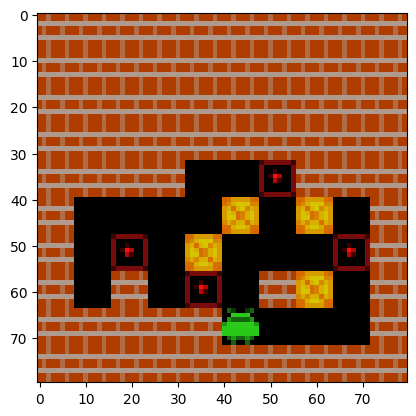

tensor([[-3.0008e-03],
        [ 1.1497e-01],
        [-1.9321e-02],
        [ 1.2748e-01],
        [ 3.2712e-01],
        [ 6.4268e-02],
        [ 1.4515e-01],
        [ 2.6107e-01],
        [-7.0306e-02],
        [-1.4643e-01],
        [-3.7516e-01],
        [-1.4747e+00],
        [-3.3316e+00],
        [-6.4096e+00]], device='cuda:0', grad_fn=<CatBackward0>) tensor([[ 0.2557],
        [ 0.4175],
        [ 0.6345],
        [ 1.5138],
        [ 3.6506],
        [ 4.5284],
        [ 5.4905],
        [ 6.8526],
        [ 8.5195],
        [10.2912],
        [14.9444],
        [26.6298],
        [38.7544],
        [42.7961],
        [44.9071]], device='cuda:0', grad_fn=<CatBackward0>)


KeyboardInterrupt: 

In [33]:
# MCTS testing

class MCTS:
    """
    Core Monte Carlo Tree Search algorithm.
    To decide on an action, we run N simulations, always starting at the root of
    the search tree and traversing the tree according to the UCB formula until we
    reach a leaf node.
    """
    def __init__(self, flags, num_actions):
        self.flags = flags
        self.num_actions = num_actions

    def run(self, model, obs, add_exploration_noise,):
        """
        At the root of the search tree we use the representation function to obtain a
        hidden state given the current observation.
        We then run a Monte Carlo Tree Search using only action sequences and the model
        learned by the network.
        Only supports a batch size of 1.        
        """
        with torch.no_grad():
            root = Node(0)
            _, root_predicted_value, policy_logits, hidden_state = model(
                obs["frame"][0], obs["last_action"], one_hot=False)
            reward = 0.
            root_predicted_value = root_predicted_value[-1].item()
            policy_logits = policy_logits[-1]
            hidden_state = hidden_state[-1]

            root.expand(num_actions, reward, policy_logits, hidden_state,)

            if add_exploration_noise:
                root.add_exploration_noise(
                    dirichlet_alpha=self.flags.root_dirichlet_alpha,
                    exploration_fraction=self.flags.root_exploration_fraction,
                )

            min_max_stats = MinMaxStats()

            max_tree_depth = 0
            
            #print("p at root:", torch.softmax(policy_logits, dim=-1))
            for k in range(self.flags.num_simulations): 
                
                #print("=======%d iteration======"%k)
                node = root
                search_path = [node]
                current_tree_depth = 0

                while node.expanded():
                    current_tree_depth += 1                    
                    action, node = self.select_child(node, min_max_stats)                    
                    search_path.append(node)
                    #print("action sel: %d" % action)
                
                #np.set_printoptions(precision=5)
                #for x in ["prior_score", "value_score", "pb_c", "prior", "visit_count"]:                    
                #    print(x, "\t", np.array([getattr(search_path[0].children[n], x) for n in range(5)]))

                # Inside the search tree we use the dynamics function to obtain the next hidden
                # state given an action and the previous hidden state
                parent = search_path[-2]     
                reward, value, policy_logits, hidden_state = model.forward_encoded(
                    parent.hidden_state, torch.tensor([[action]]).to(parent.hidden_state.device), one_hot=False)
                reward = reward[-1].item()
                value = value[-1].item()
                #print("model final output: %4f" % value)
                policy_logits = policy_logits[-1]
                hidden_state = hidden_state[-1]
                node.expand(num_actions, reward, policy_logits, hidden_state)
                self.backpropagate(search_path, value, min_max_stats)
                max_tree_depth = max(max_tree_depth, current_tree_depth)

            extra_info = {
                "max_tree_depth": max_tree_depth,
                "root_predicted_value": root_predicted_value,
            }
        return root, extra_info

    def select_child(self, node, min_max_stats):
        """
        Select the child with the highest UCB score.
        """
        max_ucb = max(
            self.ucb_score(node, child, min_max_stats)
            for action, child in node.children.items()
        )
        action = np.random.choice(
            [
                action
                for action, child in node.children.items()
                if self.ucb_score(node, child, min_max_stats) == max_ucb
            ]
        )
        return action, node.children[action]

    def ucb_score(self, parent, child, min_max_stats):
        """
        The score for a node is based on its value, plus an exploration bonus based on the prior.
        """
        pb_c = (
            math.log(
                (parent.visit_count + self.flags.pb_c_base + 1) / self.flags.pb_c_base
            )
            + self.flags.pb_c_init
        )
        pb_c *= math.sqrt(parent.visit_count) / (child.visit_count + 1)

        prior_score = pb_c * child.prior

        if child.visit_count > 0:
            # Mean value Q
            value_score = min_max_stats.normalize(
                child.reward + self.flags.discounting * child.value())
        else:
            value_score = 0
            
        child.pb_c = pb_c
        child.prior_score = prior_score
        child.value_score = value_score
        
        return prior_score + value_score

    def backpropagate(self, search_path, value, min_max_stats):
        """
        At the end of a simulation, we propagate the evaluation all the way up the tree
        to the root.
        """
        #print("bs value: %.4f" % value)
        for n, node in enumerate(reversed(search_path)):
            node.value_sum += value
            node.visit_count += 1
            min_max_stats.update(node.reward + self.flags.discounting * node.value())
            value = node.reward + self.flags.discounting * value
            #print("%d - val: %.4f r: %.4f" % (n, value, node.reward))
            #print("node value_sum %.4f" % node.value_sum)

class Node:
    def __init__(self, prior):
        self.visit_count = 0
        self.prior = prior
        self.value_sum = 0
        self.children = {}
        self.hidden_state = None
        self.reward = 0

    def expanded(self):
        return len(self.children) > 0

    def value(self):
        if self.visit_count == 0:
            return 0
        return self.value_sum / self.visit_count

    def expand(self, num_actions, reward, policy_logits, hidden_state):
        """
        We expand a node using the value, reward and policy prediction obtained from the
        neural network.
        """
        self.reward = reward
        self.hidden_state = hidden_state
        policy_values = torch.softmax(policy_logits[0], dim=0).tolist()
        for a in range(num_actions):
            self.children[a] = Node(policy_values[a])

    def add_exploration_noise(self, dirichlet_alpha, exploration_fraction):
        """
        At the start of each search, we add dirichlet noise to the prior of the root to
        encourage the search to explore new actions.
        """
        actions = list(self.children.keys())
        noise = np.random.dirichlet([dirichlet_alpha] * len(actions))
        frac = exploration_fraction
        for a, n in zip(actions, noise):
            self.children[a].prior = self.children[a].prior * (1 - frac) + n * frac

class MinMaxStats:
    """
    A class that holds the min-max values of the tree.
    """

    def __init__(self):
        self.maximum = -float("inf")
        self.minimum = float("inf")

    def update(self, value):
        self.maximum = max(self.maximum, value)
        self.minimum = min(self.minimum, value)

    def normalize(self, value):
        if self.maximum > self.minimum:
            # We normalize only when we have set the maximum and minimum values
            return (value - self.minimum) / (self.maximum - self.minimum)
        return value            

def select_action(node, temperature):
    """
    Select action according to the visit count distribution and the temperature.
    The temperature is changed dynamically with the visit_softmax_temperature function
    in the config.
    """
    visit_counts = np.array(
        [child.visit_count for child in node.children.values()], dtype="int32"
    )
    actions = [action for action in node.children.keys()]
    if temperature == 0:
        action = actions[np.argmax(visit_counts)]
    elif temperature == float("inf"):
        action = np.random.choice(actions)
    else:
        # See paper appendix Data Generation
        visit_count_distribution = visit_counts ** (1 / temperature)
        visit_count_distribution = visit_count_distribution / sum(
            visit_count_distribution
        )
        action = np.random.choice(actions, p=visit_count_distribution)
    #print("visit_counts", visit_counts)
    #print("visit_count_distribution", visit_count_distribution)
    return action
    
    
parser = argparse.ArgumentParser()      
flags = parser.parse_args([])   

env = SokobanWrapper(gym.make("Sokoban-v0"), noop=True)
env = Environment(env)
env.initial()
obs_shape, num_actions = env.gym_env.observation_space.shape, env.gym_env.action_space.n

parser = argparse.ArgumentParser()
flags = parser.parse_args([])   
flags.discounting = 0.97
flags.pb_c_init = 1.25
flags.pb_c_base = 19652
flags.root_dirichlet_alpha = 0.25
flags.root_exploration_fraction = 0.
flags.num_simulations = 3
flags.temp = 0.5
flags.device = torch.device("cuda")

eps_n = 10
eps_n_cur = 0

model = Model(flags, obs_shape, num_actions=num_actions).to(device=flags.device)
checkpoint = torch.load("../models/model_1.tar")
model.load_state_dict(checkpoint["model_state_dict"])  

obs = env.initial()
returns = []
mcts = MCTS(flags, num_actions)
obs = {k:v.to(flags.device) for k, v in obs.items()}
root, extra_info = mcts.run(model, obs, add_exploration_noise=True)   

plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
plt.show()

actions = torch.tensor([0, 1, 3, 4, 4, 4, 2, 4, 2, 2, 2, 1, 1, 1, 1]).long().to(flags.device).reshape(-1, 1)
reward, value, policy_logits, hidden_state  = model(obs["frame"][0], actions, one_hot=False)
print(reward, value)

while(len(returns) <= eps_n):
    cur_returns = obs['episode_return']    
    obs = {k:v.to(flags.device) for k, v in obs.items()}
    root, extra_info = mcts.run(model, obs, add_exploration_noise=True)    
    new_action = select_action(root, flags.temp)    
    #plt.imshow(torch.swapaxes(torch.swapaxes(obs['frame'][0,0].to(
    #flags.device).clone().cpu(),0,2),0,1), interpolation='nearest')
    #plt.show()
    #print("action selected", new_action)
    #print("===========================================")
    obs = env.step(torch.tensor([new_action]))
    if torch.any(obs['done']):
        returns.extend(cur_returns[obs['done']].numpy())
    if eps_n_cur <= len(returns) and len(returns) > 0: 
        eps_n_cur = len(returns) + 10
print("Finish %d episode: avg. return: %.2f (+-%.2f) " % (len(returns),
            np.average(returns), np.std(returns) / np.sqrt(len(returns))))

In [ ]:
# Test planning algorithm
bsz = 1
env = gym.vector.SyncVectorEnv([lambda: SokobanWrapper(gym.make("Sokoban-v0"), noop=True)] * bsz)
env = Vec_Environment(env, bsz)
obs = env.initial()
state = obs['frame'][0].to(flags.device).clone()
action = torch.zeros(bsz).long().to(flags.device)
encoded = None

In [ ]:
action = torch.Tensor([4]).long().to(flags.device)
obs = env.step(action)
state = obs['frame'][0].to(flags.device).clone()

In [ ]:
plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
from matplotlib import pyplot as plt
import logging
logging.getLogger('matplotlib.font_manager').disabled = True
device = flags.device

for _ in range(1):
    plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
    plt.show()
    ret = np.zeros((5, 5, 5))
    for i in range(5):
        for j in range(5):
            for k in range(5):
                test_action_seq = [i,j,k]
                test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
                old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
                rs, vs, logits, encodeds = model(state, old_new_actions)
                ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
    print(np.max(ret), (np.max(ret) == ret).nonzero())    
    new_action = torch.Tensor((np.max(ret) == ret).nonzero()[0]).long().to(flags.device)
    #obs = env.step(new_action)
    #state = obs['frame'][0].to(flags.device).clone()
    #action = new_action            

In [ ]:
action, prob, q_ret = n_step_greedy_model(state, action, model, 3, encoded=None, temp=10.)
print("action: ", action)
print("prob: ", prob)
print("q_ret: ", q_ret)

In [ ]:
test_action_seq = [2,3,1]
test_action_seq = torch.Tensor(test_action_seq).unsqueeze(-1).long().to(device)  
old_new_actions = torch.concat([action.unsqueeze(0), test_action_seq], dim=0)
rs, vs, logits, encodeds = model(state, old_new_actions)
ret[i, j, k] = rs[0] + rs[1] * 0.97 + rs[2] * (0.97**2) + vs[-1] * (0.97**3)
print("rs", rs)
print("vs", vs)
print("logits", logits)
print("ret", ret[i,j,k])

In [ ]:
temp = 10.

bsz = state.shape[0]
device = state.device 
num_actions = model.num_actions    
model.train(False)

q_ret = torch.zeros(bsz, num_actions).to(device)        
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)        

for act in range(num_actions):        
    new_action = torch.Tensor(np.full(bsz, act)).long().to(device)    
    old_new_actions = torch.concat([action.unsqueeze(0), new_action.unsqueeze(0)], dim=0)
    rs, vs, logits, encodeds = model(state, old_new_actions)
    ret = rs[0] + flags.discounting * vs[1]
    rs_act[:, act] = rs[0]
    vs_act[:, act] = vs[1]
    q_ret[:, act] = ret

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

In [ ]:
device = flags.device
net_state = env.clone_state()

bsz = 1
temp = 10.
q_ret = torch.zeros(bsz, num_actions).to(device)      
rs_act = torch.zeros(bsz, num_actions).to(device)        
vs_act = torch.zeros(bsz, num_actions).to(device)   

net = net.to(device)

for act in range(num_actions):
    obs = env.step(torch.Tensor(np.full(bsz, act)).long())      
    obs = {k:v.to(device) for k, v in obs.items()}   
    ret = obs['reward'] + flags.discounting * net(obs)[0]['baseline'] * (~obs['done']).float()
    rs_act[:, act] = obs['reward']
    vs_act[:, act] = net(obs)[0]['baseline']
    q_ret[:, act] = ret
    env.restore_state(net_state)

prob = F.softmax(temp*q_ret, dim=1)
action = torch.multinomial(prob, num_samples=1)[:, 0]

print("rs_act", rs_act)
print("vs_act", vs_act)
print("q_ret", q_ret)
print("prob", prob)

plt.imshow(torch.swapaxes(torch.swapaxes(state[0].cpu(),0,2),0,1), interpolation='nearest')
plt.show()

In [ ]:
batch = get_batch_m(flags, buffers)
print(torch.max(batch["reward"]), (torch.max(batch["reward"]) == batch["reward"]).nonzero())
print(batch["done"].nonzero())

In [ ]:
# DEBUG LOSS

#batch = get_batch_m(flags, buffers)

model.train(False)

rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
logits = logits[:-1]

target_rewards = batch['reward'][1:]
target_logits = batch['policy_logits'][1:]

target_vs = []
target_v = model(batch['frame'][-1], batch['action'][[-1]])[1][0]    

for t in range(vs.shape[0]-1, 0, -1):
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    target_vs.append(new_target_v.unsqueeze(0))
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)

# if done on step j, r_{j}, v_{j-1}, a_{j-1} has the last valid loss 
# rs is stored in the form of r_{t+1}, ..., r_{t+k}
# vs is stored in the form of v_{t}, ..., v_{t+k-1}
# logits is stored in the form of a{t}, ..., a_{t+k-1}

done_masks = []
done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)
for t in range(vs.shape[0]):
    done = torch.logical_or(done, batch['done'][t])
    done_masks.append(done.unsqueeze(0))

done_masks = torch.concat(done_masks[:-1], dim=0)

# compute final loss
huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
rs_loss = torch.sum(huberloss(rs, target_rewards) * (~done_masks).float())
#rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
vs_loss = torch.sum(huberloss(vs[:-1], target_vs) * (~done_masks).float())
#vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
logits_loss = compute_cross_entropy_loss(logits, target_logits, done_masks)

# debug
ind = 21

target_vs = []
target_v = vs[-1]
for t in range(vs.shape[0]-1, 0, -1):        
    new_target_v = batch['reward'][t] + flags.discounting * (target_v * (~batch['done'][t]).float() +
                       vs[t-1] * (batch['truncated_done'][t]).float())
    print(t, 
          "reward %2f" % batch['reward'][t,ind].item(), 
          "bootstrap %2f" % (target_v * (~batch['done'][t]).float())[ind].item(), 
          "truncated %2f" % (vs[t-1] * (batch['truncated_done'][t]).float())[ind].item(),
          "vs[t-1] %2f" % vs[t-1][ind].item(),
          "new_targ %2f" % new_target_v[ind].item())
    target_vs.append(new_target_v.unsqueeze(0))    
    target_v = new_target_v
target_vs.reverse()
target_vs = torch.concat(target_vs, dim=0)   
print("done", batch["done"][:, ind])
print("done_masks", done_masks[:, ind])
print("vs: ", vs[:, ind])
print("target_vs: ", target_vs[:, ind])
print("reward: ", rs[:, ind])
print("target_reward: ", target_rewards[:, ind])
print("logits: ", logits[:, ind])
print("target_logits: ", target_logits[:, ind])

In [ ]:
# alt. version of computing loss by treading terminal state as absorbing state (as in MuZero)

def compute_loss_m(model, batch):

    rs, vs, logits, _ = model(batch['frame'][0], batch['action'])
    logits = logits[:-1]

    target_logits = batch['policy_logits'][1:].clone()
    target_rewards = batch['reward'][1:].clone()

    done_masks = []
    done = torch.zeros(vs.shape[1]).bool().to(batch['done'].device)

    c_logits = target_logits[0]
    c_state = batch['frame'][0]
    for t in range(vs.shape[0]-1):
        if t > 0: done = torch.logical_or(done, batch['done'][t])
        c_logits = torch.where(done.unsqueeze(-1), c_logits, target_logits[t])
        target_logits[t] = c_logits
        c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][t])  
        done_masks.append(done.unsqueeze(0))
    done_masks = torch.concat(done_masks, dim=0)
    done = torch.logical_or(done, batch['done'][-1])
    c_state = torch.where(done.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1), c_state, batch['frame'][-1])
    target_rewards = target_rewards * (~done_masks).float()

    target_vs = []
    target_v = model(c_state, batch['action'][[-1]])[1][0].detach()
    
    for t in range(vs.shape[0]-1, 0, -1):
        new_target_v = batch['reward'][t] + flags.discounting * target_v
        target_vs.append(new_target_v.unsqueeze(0))
        target_v = new_target_v
    target_vs.reverse()
    target_vs = torch.concat(target_vs, dim=0)
    
    # compute final loss
    huberloss = torch.nn.HuberLoss(reduction='none', delta=1.0)    
    rs_loss = torch.sum(huberloss(rs, target_rewards.detach()))
    #rs_loss = torch.sum(((rs - target_rewards) ** 2) * (~r_logit_done_masks).float())
    vs_loss = torch.sum(huberloss(vs[:-1], target_vs.detach()))
    #vs_loss = torch.sum(((vs[:-1] - target_vs) ** 2) * (~v_done_masks).float())
    logits_loss = compute_cross_entropy_loss(logits, target_logits.detach(), None)
    
    return rs_loss, vs_loss, logits_loss